# DANetの実装(モデル構築、学習、推論)

- データは環境音データセットである[ESC-50](https://github.com/karolpiczak/ESC-50)を使用

## パッケージのインストールとインポート

- librosaは音声の処理に用いる

In [1]:
!pip install -U librosa

Requirement already up-to-date: librosa in /usr/local/lib/python3.7/dist-packages (0.8.0)


- musevalはSDR,SAR,SIRを計算するのに用いる(分解音性能を評価するのに用いる)

In [2]:
!pip install museval

     |████████████████████████████████| 133kB 44.7MB/s 
     |████████████████████████████████| 972kB 27.6MB/s 


- パッケージのインポート

In [3]:
import tensorflow as tf
import museval
import itertools
import soundfile as sf
import pandas
import numpy as np
import scipy
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

## データの前処理

### ラベル

In [4]:
!unzip /content/drive/MyDrive/DANet/ESC-50-master.zip

Archive:  /content/drive/MyDrive/DANet/ESC-50-master.zip
d2f61c91f7ab7f204fcff13f7335a43b00f91c1f
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-master/.circleci/config.yml  
   creating: ESC-50-master/.github/
  inflating: ESC-50-master/.github/stale.yml  
 extracting: ESC-50-master/.gitignore  
  inflating: ESC-50-master/LICENSE   
  inflating: ESC-50-master/README.md  
   creating: ESC-50-master/audio/
  inflating: ESC-50-master/audio/1-100032-A-0.wav  
  inflating: ESC-50-master/audio/1-100038-A-14.wav  
  inflating: ESC-50-master/audio/1-100210-A-36.wav  
  inflating: ESC-50-master/audio/1-100210-B-36.wav  
  inflating: ESC-50-master/audio/1-101296-A-19.wav  
  inflating: ESC-50-master/audio/1-101296-B-19.wav  
  inflating: ESC-50-master/audio/1-101336-A-30.wav  
  inflating: ESC-50-master/audio/1-101404-A-34.wav  
  inflating: ESC-50-master/audio/1-103298-A-9.wav  
  inflating: ESC-50-master/audio/1-103995-A-30.wav  
  inflating: ESC-50-mast

- 音の種類とファイル名の対応を表すラベルを作成し、音の種類でソートする

In [5]:
labels = pandas.read_csv("/content/ESC-50-master/meta/esc50.csv")
labels = labels.sort_values(by=["category","filename"])

- ソートされた音の順番を示すnumpy.ndarrayを生成

In [6]:
sound_names = np.asarray(labels.loc[:,"category"].value_counts().sort_index().index)

- 音の種類でソートされた音声ファイルのファイル名を示すnumpy.ndarrayを生成

In [7]:
wav_filenames = labels.loc[:,"filename"]
wav_filenames = np.asarray(wav_filenames)

### 音声の処理(リサンプリング、短時間フーリエ変換)

- 音声をロードし、サンプリングレートも記録する

In [8]:
sounds = list()
sampling_rates = list()
for name in wav_filenames:
  y,sr = librosa.load("/content/ESC-50-master/audio/" + name)
  sounds.append(y)
  sampling_rates.append(sr)

- 論文に合わせるため、8000Hzにリサンプリングする

In [9]:
sounds_resampled = list()
for i in range(len(sounds)):
  resampled = librosa.resample(sounds[i], sampling_rates[i], 8000)
  sounds_resampled.append(resampled)

- 窓関数(ハニング窓の平方根)を定義

In [10]:
def square_root_of_hann(M, sym=False):
  w = scipy.signal.windows.hann(M, sym)
  w = np.sqrt(w)
  return w

- 短時間フーリエ変換(STFT)を行う(hop_length,win_lengthは論文の指定通り)

In [11]:
Fouriers = list()
for i in range(len(sounds_resampled)):
  Fourier = librosa.stft(sounds_resampled[i], n_fft=256, hop_length=64, win_length=256, window=square_root_of_hann)
  Fouriers.append(Fourier)
Fouriers = np.asarray(Fouriers)

- 全種類の音から一つずつ選び、そのスペクトログラムを表示

In [ ]:
#all kind of sounds
fig = plt.figure(figsize=(10*7,4*8))
for i in range(50):
  plt.subplot(8,7,i+1)
  librosa.display.specshow(librosa.amplitude_to_db(np.abs(Fouriers[40*i])),y_axis='linear', x_axis='time',sr=8000)
  plt.colorbar(format='%+2.0f dB')

fig.savefig("Fourier.png")

Output hidden; open in https://colab.research.google.com to view.

## モデルの構築

### レイヤ

- 推論時に位相を持ったスペクトログラムを入力されたとき、前処理するレイヤ

In [12]:
class Preparation(tf.keras.layers.Layer):
  def __init__(self, log_eps,  *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.log_eps = log_eps

  def call(self, input, training):
    if training:
      return input
    else:
      model_input = tf.math.log(tf.math.abs(input) + self.log_eps)
      return model_input

- アトラクターを生成するレイヤ(訓練時はideal mask、推論時はkmeansを使う)

In [13]:
class Attractor(tf.keras.layers.Layer):
  def __init__(self, kmeans_func, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.kmeans_func = kmeans_func
  
  def call(self, input, training):
    if training:
      att_num = tf.einsum('Ncft,Nftk->Nck',input[0],input[1])
      att_denom = tf.math.reduce_sum(input[0],axis=[2,3]) # batch_size, c
      att_denom = tf.reshape(att_denom,[-1,2,1])
      attractor = att_num / att_denom
    else:
      attractor = self.kmeans_func(input[0])
      attractor = tf.convert_to_tensor(attractor)
    
    return attractor

- maskを混合音声に掛けて音声を分離するレイヤ(推論時には混合音声が位相のある複素数のデータになる)

In [14]:
class Make_clean_reference(tf.keras.layers.Layer):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def call(self, input, training):
    if training:
      clean_reference = tf.einsum('Nft,Nftc->Nftc',input[0],input[1])
      return clean_reference
    else:
      clean_reference = tf.einsum('Nft,Nftc->Nftc',tf.cast(input[0], dtype=tf.complex64),tf.cast(input[1], dtype=tf.complex64))
      return clean_reference

### モデル

- モデルを構築

In [23]:
class DANet(tf.keras.Model):
  def __init__(self, source_num, embed_ndim, batch_size, log_eps=0.0001, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.source_num = source_num
    self.embed_ndim = embed_ndim
    self.log_eps = log_eps
    self.batch_size = batch_size
    self.cluster_centers_list = np.ones(shape=(self.batch_size,self.source_num,self.embed_ndim))

    self.preparation = Preparation(self.log_eps)
    self.reshape = tf.keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0,2,1]))
    self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300,return_sequences=True),merge_mode='concat')
    self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300,return_sequences=True),merge_mode='concat')
    self.lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300,return_sequences=True),merge_mode='concat')
    self.lstm4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300,return_sequences=True),merge_mode='concat')
    self.embedding1 = tf.keras.layers.Dense(129*self.embed_ndim)
    self.embedding2 = tf.keras.layers.Reshape((100,129,self.embed_ndim))
    self.embedding3 = tf.keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0,2,1,3]))
    self.make_attractor = Attractor(self.kmeans_predict)
    self.make_mask = tf.keras.layers.Lambda(lambda x: tf.einsum('Nftk,Nck->Nftc',x[0],x[1]))
    self.make_clean_reference = Make_clean_reference()
  
  def call(self,inputs,training):
    x1 = self.preparation(inputs[0], training)
    x1 = self.reshape(x1)
    x1 = self.lstm1(x1)
    x1 = self.lstm2(x1)
    x1 = self.lstm3(x1)
    x1 = self.lstm4(x1)
    x1 = self.embedding1(x1)
    x1 = self.embedding2(x1)
    x1 = self.embedding3(x1)
    attractor = self.make_attractor([inputs[1],x1], training)
    mask = tf.keras.activations.softmax(self.make_mask([x1, attractor]))
    clean_reference = self.make_clean_reference([inputs[0],mask], training)

    return clean_reference
  
  def get_embedded_data(self,inputs,training):
    x1 = self.preparation(inputs,training)
    x1 = self.reshape(x1)
    x1 = self.lstm1(x1)
    x1 = self.lstm2(x1)
    x1 = self.lstm3(x1)
    x1 = self.lstm4(x1)
    x1 = self.embedding1(x1)
    x1 = self.embedding2(x1)
    output = self.embedding3(x1)
    
    return output
  
  def kmeans_fit(self, inputs, max_iter=1000, random_seed=0):
    embedded_data = self.get_embedded_data(inputs, training=False)

    shape = embedded_data.shape
    embedded_data = np.reshape(embedded_data, newshape=(shape[0], shape[1]*shape[2], shape[3]))

    cluster_centers_list = list()

    for n in range(len(inputs)):
      X = embedded_data[n]
      random_state = np.random.RandomState(random_seed)
  
      cycle = itertools.cycle(range(self.source_num))
      labels = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
      random_state.shuffle(labels)
      labels_prev = np.zeros(X.shape[0])
      cluster_centers = np.zeros((self.source_num, X.shape[1]))
    
      for i in range(max_iter):
        for k in range(self.source_num):
          XX = X[labels == k,:]
          cluster_centers[k,:] = XX.mean(axis=0)
      
        dist = ((X[:,:,np.newaxis] - cluster_centers.T[np.newaxis,:,:])**2).sum(axis=1)
        labels_prev = labels
        labels = dist.argmin(axis=1)

        for k in range(self.source_num):
          if not np.any(labels == k):
            labels[np.random.choice(len(labels),1)] = k

        if (labels == labels_prev).all():
          break
      
      for k in range(self.source_num):
          XX = X[labels == k,:]
          cluster_centers[k,:] = XX.mean(axis=0)
      
      cluster_centers_list.append(cluster_centers)

    self.cluster_centers_list = np.asarray(cluster_centers_list)


  def kmeans_predict(self, input):
    return self.cluster_centers_list

  def get_batch_size(self):
    return self.batch_size
  
  def set_batch_size(self, batch_size):
    self.batch_size = batch_size
    self.cluster_centers_list = np.ones(shape=(self.batch_size, self.source_num, self.embed_ndim))
  
  def prediction(self, input):
    self.kmeans_fit(input)
    fake_ideal_mask = np.zeros(shape=(input.shape[0],2,129,100))
    result = self.predict([input, fake_ideal_mask],batch_size=len(input))
    return result
  
  def loading(self, path):
    input1 = np.zeros(shape=(self.batch_size,129,100))
    input2 = np.zeros(shape=(self.batch_size,2,129,100))
    temp = model.predict(x=[input1,input2],batch_size=self.batch_size)
    self.load_weights(path)

## 学習、推論の準備

### 入力データ生成

- テストデータを生成するクラス

for_kmeansでkmeansのクラスタリング用(model.kmeans_fit)のデータを生成する  
for_predictで推論(model.predict)に使うデータを生成する  
generate_dataでkmeansクラスタリングと推論をまとめて行うメソッド(model.prediction)用のデータを生成する

In [16]:
class all_test_data():
  def __init__(self, Fouriers, sound_names):
    self.Fouriers = Fouriers
    self.sound_names = sound_names

  def for_kmeans(self, sound1, sound2):
  
    train_num = [0, 0]
    iterate_num = 0

    for i in range(len(self.sound_names)):
      if sound1 == self.sound_names[i]:
        train1 = self.Fouriers[40*i+35:40*i+40]
      if sound2 == self.sound_names[i]:
        train2 = self.Fouriers[40*i+35:40*i+40]
    
    try:
      if 'train1' not in locals():
        raise NameError('sound1 was not found.')
      if 'train2' not in locals():
        raise NameError('sound2 was not found.')
    except NameError as message:
      print(message)

    mixture = list()
    while True:
      first = train1[train_num[0]]
      second = train2[train_num[1]]

      try:
        if first.shape[-1]<100:
          raise TypeError("The data is too short.")
      except TypeError as message:
        print(message)
      

      if first.shape[-1]>100:
        if first.shape[-1]<(iterate_num+1)*100:
          first = np.concatenate((first[:,iterate_num*100:], first[:,:(100-(first.shape[-1]-iterate_num*100))]), axis=1)
          second = np.concatenate((second[:,iterate_num*100:], second[:,:(100-(second.shape[-1]-iterate_num*100))]), axis=1)
          
          train_num[1] += 1
          if len(train2) == train_num[1]:
            train_num[0] += 1
            train_num[1] = 0
            if len(train1) == train_num[0]:
              train_num[0] = 0
          iterate_num = 0
        else:
          first = first[:,iterate_num*100:(iterate_num+1)*100]
          second = second[:,iterate_num*100:(iterate_num+1)*100]
          iterate_num += 1
      else:
        train_num[1] += 1
        if len(train2) == train_num[1]:
          train_num[0] += 1
          train_num[1] = 0
          if len(train1) == train_num[0]:
            train_num[0] = 0
      
      mix = first + second

      mixture.append(mix)

      if train_num == [0,0] and iterate_num == 0:
        x_test = np.asarray(mixture)

        mixture = list()

        return x_test

  def for_predict(self, sound1, sound2):
  
    train_num = [0, 0]
    iterate_num = 0

    for i in range(len(self.sound_names)):
      if sound1 == self.sound_names[i]:
        train1 = self.Fouriers[40*i+35:40*i+40]
      if sound2 == self.sound_names[i]:
        train2 = self.Fouriers[40*i+35:40*i+40]
    
    try:
      if 'train1' not in locals():
        raise NameError('sound1 was not found.')
      if 'train2' not in locals():
        raise NameError('sound2 was not found.')
    except NameError as message:
      print(message)

    before = list()
    mixture = list()
    while True:
      first = train1[train_num[0]]
      second = train2[train_num[1]]

      try:
        if first.shape[-1]<100:
          raise TypeError("The data is too short.")
      except TypeError as message:
        print(message)
      

      if first.shape[-1]>100:
        if first.shape[-1]<(iterate_num+1)*100:
          first = np.concatenate((first[:,iterate_num*100:], first[:,:(100-(first.shape[-1]-iterate_num*100))]), axis=1)
          second = np.concatenate((second[:,iterate_num*100:], second[:,:(100-(second.shape[-1]-iterate_num*100))]), axis=1)
          
          train_num[1] += 1
          if len(train2) == train_num[1]:
            train_num[0] += 1
            train_num[1] = 0
            if len(train1) == train_num[0]:
              train_num[0] = 0
          iterate_num = 0
        else:
          first = first[:,iterate_num*100:(iterate_num+1)*100]
          second = second[:,iterate_num*100:(iterate_num+1)*100]
          iterate_num += 1
      else:
        train_num[1] += 1
        if len(train2) == train_num[1]:
          train_num[0] += 1
          train_num[1] = 0
          if len(train1) == train_num[0]:
            train_num[0] = 0
      
      mix = first + second

      before.append([first, second])
      mixture.append(mix)

      if train_num == [0,0] and iterate_num == 0:
        x_test1 = np.asarray(mixture)
        x_test2 = np.zeros(shape=(x_test1.shape[0],2,129,100))
        y_test = np.asarray(before)

        mixture = list()
        before = list()

        return [x_test1, x_test2], y_test
  
  def generate_data(self, sound1, sound2):
    train_num = [0, 0]
    iterate_num = 0

    for i in range(len(self.sound_names)):
      if sound1 == self.sound_names[i]:
        train1 = self.Fouriers[40*i+35:40*i+40]
      if sound2 == self.sound_names[i]:
        train2 = self.Fouriers[40*i+35:40*i+40]
    
    try:
      if 'train1' not in locals():
        raise NameError('sound1 was not found.')
      if 'train2' not in locals():
        raise NameError('sound2 was not found.')
    except NameError as message:
      print(message)

    before = list()
    mixture = list()
    while True:
      first = train1[train_num[0]]
      second = train2[train_num[1]]

      try:
        if first.shape[-1]<100:
          raise TypeError("The data is too short.")
      except TypeError as message:
        print(message)
      

      if first.shape[-1]>100:
        if first.shape[-1]<(iterate_num+1)*100:
          first = np.concatenate((first[:,iterate_num*100:], first[:,:(100-(first.shape[-1]-iterate_num*100))]), axis=1)
          second = np.concatenate((second[:,iterate_num*100:], second[:,:(100-(second.shape[-1]-iterate_num*100))]), axis=1)
          
          train_num[1] += 1
          if len(train2) == train_num[1]:
            train_num[0] += 1
            train_num[1] = 0
            if len(train1) == train_num[0]:
              train_num[0] = 0
          iterate_num = 0
        else:
          first = first[:,iterate_num*100:(iterate_num+1)*100]
          second = second[:,iterate_num*100:(iterate_num+1)*100]
          iterate_num += 1
      else:
        train_num[1] += 1
        if len(train2) == train_num[1]:
          train_num[0] += 1
          train_num[1] = 0
          if len(train1) == train_num[0]:
            train_num[0] = 0
      
      mix = first + second

      before.append([first, second])
      mixture.append(mix)

      if train_num == [0,0] and iterate_num == 0:
        x_test = np.asarray(mixture)
        y_test = np.asarray(before)

        mixture = list()
        before = list()

        return x_test, y_test

- 訓練データを生成するジェネレータを含むクラス

In [17]:
class generator():
  def __init__(self, Fouriers, sound_names):
    self.train_num = [0, 0]
    self.iterate_num = 0
    self.Fouriers = Fouriers
    self.sound_names = sound_names

  def generator_train(self, sound1, sound2, batch_size, initialize=True):
    if initialize:
      self.train_num = [0, 0]
      self.iterate_num = 0

    for i in range(len(self.sound_names)):
      if sound1 == self.sound_names[i]:
        train1 = self.Fouriers[40*i:40*i+35]
      if sound2 == self.sound_names[i]:
        train2 = self.Fouriers[40*i:40*i+35]
    
    try:
      if 'train1' not in locals():
        raise NameError('sound1 was not found.')
      if 'train2' not in locals():
        raise NameError('sound2 was not found.')
    except NameError as message:
      print(message)

    mixture = list()
    ideal_mask = list()
    correct = list()
    while True:
      first = train1[self.train_num[0]]
      second = train2[self.train_num[1]]

      try:
        if first.shape[-1]<100:
          raise TypeError("The data is too short.")
      except TypeError as message:
        print(message)
      

      if first.shape[-1]>100:
        if first.shape[-1]<(self.iterate_num+1)*100:
          first = np.concatenate((first[:,self.iterate_num*100:], first[:,:(100-(first.shape[-1]-self.iterate_num*100))]), axis=1)
          second = np.concatenate((second[:,self.iterate_num*100:], second[:,:(100-(second.shape[-1]-self.iterate_num*100))]), axis=1)
          
          self.train_num[1] += 1
          if len(train2) == self.train_num[1]:
            self.train_num[0] += 1
            self.train_num[1] = 0
            if len(train1) == self.train_num[0]:
              self.train_num[0] = 0
          self.iterate_num = 0
        else:
          first = first[:,self.iterate_num*100:(self.iterate_num+1)*100]
          second = second[:,self.iterate_num*100:(self.iterate_num+1)*100]
          self.iterate_num += 1
      else:
        self.train_num[1] += 1
        if len(train2) == self.train_num[1]:
          self.train_num[0] += 1
          self.train_num[1] = 0
          if len(train1) == self.train_num[0]:
            self.train_num[0] = 0
      
      with np.errstate(all="raise"):
        mix = first + second
        mix = np.log(np.abs(mix)+0.0001)

        first = np.log(np.abs(first)+0.0001)
        second = np.log(np.abs(second)+0.0001)

        mixture.append(mix)
        correct.append(np.transpose(np.asarray([first, second]),axes=[1,2,0]))
        max = np.max(np.asarray([first, second]), axis=0)
        first = np.logical_not(first - max).astype(np.float32)
        second = np.logical_not(second - max).astype(np.float32)
        if not np.any(first):
          #print('first is zeros')
          mixture.pop()
          correct.pop()
          continue
        if not np.any(second):
          #print('second is zeros')
          mixture.pop()
          correct.pop()
          continue
        ideal_mask.append([first, second])

        if len(mixture) == batch_size:
          x_train1 = np.asarray(mixture)
          x_train2 = np.asarray(ideal_mask)
          y_train = np.asarray(correct)

          mixture = list()
          ideal_mask = list()
          correct = list()

          yield [x_train1, x_train2], y_train
  
  def get_batch_and_steps(self, model):
    batch_size = model.get_batch_size()
    steps = (((self.Fouriers.shape[-1]//100)+1)*35*35) // batch_size
    return batch_size, steps

### モデル生成

- モデルを生成

In [64]:
model = DANet(source_num=2,embed_ndim=20,batch_size=25, log_eps=0.0001)

- 損失関数を定義

In [65]:
def loss_function(y_true, y_pred):
  frequency = tf.shape(y_true)[1]
  time = tf.shape(y_true)[2]
  frequency = tf.cast(frequency, tf.float32)
  time = tf.cast(time, tf.float32)
  return tf.reduce_sum((y_true - y_pred)**2) / (frequency*time)

- 学習率の減衰をするスケジューラを設定

In [66]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=51450,decay_rate=0.03)

- モデルをコンパイル

In [67]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),loss=loss_function)

- ジェネレータを含むクラスにデータを渡し、インスタンスを生成

In [24]:
Generator = generator(Fouriers, sound_names)

- バッチサイズ、ステップ(1エポックに何バッチ訓練するか)を設定

In [25]:
batch_size, steps = Generator.get_batch_and_steps(model)

## 学習結果

### train and frog

In [ ]:
model.fit(x=Generator.generator_train('train','frog',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 51s 123ms/step - loss: 257.3318
Epoch 2/20
343/343 [==============================] - 42s 122ms/step - loss: 250.4023
Epoch 3/20
343/343 [==============================] - 42s 123ms/step - loss: 248.0015
Epoch 4/20
343/343 [==============================] - 42s 123ms/step - loss: 246.5048
Epoch 5/20
343/343 [==============================] - 42s 123ms/step - loss: 245.3918
Epoch 6/20
343/343 [==============================] - 42s 123ms/step - loss: 244.5766
Epoch 7/20
343/343 [==============================] - 42s 123ms/step - loss: 244.0711
Epoch 8/20
343/343 [==============================] - 42s 123ms/step - loss: 243.4974
Epoch 9/20
343/343 [==============================] - 42s 122ms/step - loss: 243.1181
Epoch 10/20
343/343 [==============================] - 42s 122ms/step - loss: 242.6262
Epoch 11/20
343/343 [==============================] - 42s 123ms/step - loss: 242.2905
Epoch 12/20
343/343 [==============================]

In [ ]:
model.fit(x=Generator.generator_train('train','frog',batch_size), steps_per_epoch=steps, epochs=40, initial_epoch=20)

Epoch 21/40
343/343 [==============================] - 42s 124ms/step - loss: 242.6671
Epoch 22/40
343/343 [==============================] - 42s 121ms/step - loss: 242.5738
Epoch 23/40
343/343 [==============================] - 42s 122ms/step - loss: 242.4570
Epoch 24/40
343/343 [==============================] - 42s 122ms/step - loss: 242.3419
Epoch 25/40
343/343 [==============================] - 42s 122ms/step - loss: 242.2749
Epoch 26/40
343/343 [==============================] - 42s 122ms/step - loss: 242.1520
Epoch 27/40
343/343 [==============================] - 42s 122ms/step - loss: 242.0934
Epoch 28/40
343/343 [==============================] - 42s 123ms/step - loss: 242.0136
Epoch 29/40
343/343 [==============================] - 42s 122ms/step - loss: 241.9528
Epoch 30/40
343/343 [==============================] - 42s 122ms/step - loss: 241.8774
Epoch 31/40
343/343 [==============================] - 42s 122ms/step - loss: 241.8291
Epoch 32/40
343/343 [======================

In [ ]:
#epochs=20
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:5.1  GSAR:1e+01 GSIR:9.5 


In [ ]:
#epochs=40
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:5.1  GSAR:1e+01 GSIR:9.3 


### crackling_fire and cat

In [ ]:
model.fit(x=Generator.generator_train('crackling_fire','cat',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 51s 125ms/step - loss: 446.4658
Epoch 2/20
343/343 [==============================] - 42s 123ms/step - loss: 445.4516
Epoch 3/20
343/343 [==============================] - 42s 123ms/step - loss: 469.6045
Epoch 4/20
343/343 [==============================] - 42s 123ms/step - loss: 444.8437
Epoch 5/20
343/343 [==============================] - 42s 123ms/step - loss: 461.5573
Epoch 6/20
343/343 [==============================] - 42s 123ms/step - loss: 460.8188
Epoch 7/20
343/343 [==============================] - 42s 123ms/step - loss: 460.1562
Epoch 8/20
343/343 [==============================] - 42s 124ms/step - loss: 445.2961
Epoch 9/20
343/343 [==============================] - 42s 123ms/step - loss: 432.2737
Epoch 10/20
343/343 [==============================] - 42s 123ms/step - loss: 446.4728
Epoch 11/20
343/343 [==============================] - 42s 123ms/step - loss: 427.0284
Epoch 12/20
343/343 [==============================]

In [ ]:
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:-0.59 GSAR:1.4e+01 GSIR:9.3 


### wind and frog

In [ ]:
model.fit(x=Generator.generator_train('wind','frog',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 51s 124ms/step - loss: 271.2565
Epoch 2/20
343/343 [==============================] - 42s 123ms/step - loss: 261.7133
Epoch 3/20
343/343 [==============================] - 42s 122ms/step - loss: 258.4713
Epoch 4/20
343/343 [==============================] - 42s 122ms/step - loss: 256.7413
Epoch 5/20
343/343 [==============================] - 42s 122ms/step - loss: 255.5024
Epoch 6/20
343/343 [==============================] - 42s 122ms/step - loss: 254.5210
Epoch 7/20
343/343 [==============================] - 42s 122ms/step - loss: 253.8046
Epoch 8/20
343/343 [==============================] - 42s 122ms/step - loss: 253.0891
Epoch 9/20
343/343 [==============================] - 42s 122ms/step - loss: 252.5533
Epoch 10/20
343/343 [==============================] - 42s 122ms/step - loss: 252.0678
Epoch 11/20
343/343 [==============================] - 42s 122ms/step - loss: 251.6457
Epoch 12/20
343/343 [==============================]

In [ ]:
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:5.3  GSAR:1.2e+01 GSIR:1e+01


### wind and cat

In [ ]:
model.fit(x=Generator.generator_train('wind','cat',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 53s 127ms/step - loss: 420.1584
Epoch 2/20
343/343 [==============================] - 43s 126ms/step - loss: 407.4060
Epoch 3/20
343/343 [==============================] - 43s 125ms/step - loss: 409.4852
Epoch 4/20
343/343 [==============================] - 43s 125ms/step - loss: 404.7681
Epoch 5/20
343/343 [==============================] - 43s 125ms/step - loss: 398.8077
Epoch 6/20
343/343 [==============================] - 43s 125ms/step - loss: 391.7809
Epoch 7/20
343/343 [==============================] - 43s 125ms/step - loss: 397.0493
Epoch 8/20
343/343 [==============================] - 43s 125ms/step - loss: 392.0768
Epoch 9/20
343/343 [==============================] - 43s 126ms/step - loss: 391.8356
Epoch 10/20
343/343 [==============================] - 43s 126ms/step - loss: 387.8006
Epoch 11/20
343/343 [==============================] - 43s 126ms/step - loss: 386.4721
Epoch 12/20
343/343 [==============================]

In [ ]:
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:-1.7 GSAR:1.2e+01 GSIR:9.9 


### wind and hand_saw

In [ ]:
model.fit(x=Generator.generator_train('wind','hand_saw',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 51s 124ms/step - loss: 226.6176
Epoch 2/20
343/343 [==============================] - 42s 122ms/step - loss: 219.0179
Epoch 3/20
343/343 [==============================] - 42s 123ms/step - loss: 215.5234
Epoch 4/20
343/343 [==============================] - 42s 122ms/step - loss: 217.4454
Epoch 5/20
343/343 [==============================] - 42s 122ms/step - loss: 221.1256
Epoch 6/20
343/343 [==============================] - 42s 122ms/step - loss: 221.4538
Epoch 7/20
343/343 [==============================] - 42s 122ms/step - loss: 221.6617
Epoch 8/20
343/343 [==============================] - 42s 122ms/step - loss: 220.7982
Epoch 9/20
343/343 [==============================] - 42s 122ms/step - loss: 219.6892
Epoch 10/20
343/343 [==============================] - 42s 122ms/step - loss: 216.5148
Epoch 11/20
343/343 [==============================] - 42s 122ms/step - loss: 220.0732
Epoch 12/20
343/343 [==============================]

In [ ]:
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:1.2  GSAR:5.8  GSIR:4.0 


### train and cat

In [ ]:
model.fit(x=Generator.generator_train('train','cat',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 51s 125ms/step - loss: 421.6734
Epoch 2/20
343/343 [==============================] - 43s 124ms/step - loss: 418.6537
Epoch 3/20
343/343 [==============================] - 43s 124ms/step - loss: 420.7425
Epoch 4/20
343/343 [==============================] - 43s 124ms/step - loss: 403.7604
Epoch 5/20
343/343 [==============================] - 43s 124ms/step - loss: 404.1987
Epoch 6/20
343/343 [==============================] - 43s 124ms/step - loss: 408.5158
Epoch 7/20
343/343 [==============================] - 42s 124ms/step - loss: 409.2135
Epoch 8/20
343/343 [==============================] - 42s 124ms/step - loss: 401.6670
Epoch 9/20
343/343 [==============================] - 42s 123ms/step - loss: 403.5942
Epoch 10/20
343/343 [==============================] - 42s 124ms/step - loss: 406.5057
Epoch 11/20
343/343 [==============================] - 42s 124ms/step - loss: 400.9075
Epoch 12/20
343/343 [==============================]

In [ ]:
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:-1.7 GSAR:1.1e+01 GSIR:9.6 


### pouring_water and frog

In [ ]:
model.fit(x=Generator.generator_train('pouring_water','frog',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 52s 127ms/step - loss: 497.0374
Epoch 2/20
343/343 [==============================] - 43s 126ms/step - loss: 485.1518
Epoch 3/20
343/343 [==============================] - 43s 126ms/step - loss: 478.2170
Epoch 4/20
343/343 [==============================] - 42s 123ms/step - loss: 462.4049
Epoch 5/20
343/343 [==============================] - 43s 126ms/step - loss: 457.8445
Epoch 6/20
343/343 [==============================] - 43s 126ms/step - loss: 418.7796
Epoch 7/20
343/343 [==============================] - 43s 126ms/step - loss: 384.7701
Epoch 8/20
343/343 [==============================] - 43s 126ms/step - loss: 405.1844
Epoch 9/20
343/343 [==============================] - 43s 126ms/step - loss: 416.7485
Epoch 10/20
343/343 [==============================] - 43s 126ms/step - loss: 407.8557
Epoch 11/20
343/343 [==============================] - 43s 126ms/step - loss: 433.4742
Epoch 12/20
343/343 [==============================]

In [ ]:
model.fit(x=Generator.generator_train('pouring_water','frog',batch_size), steps_per_epoch=steps, epochs=40, initial_epoch=20)

Epoch 21/40
343/343 [==============================] - 42s 122ms/step - loss: 433.9541
Epoch 22/40
343/343 [==============================] - 42s 123ms/step - loss: 431.6522
Epoch 23/40
343/343 [==============================] - 43s 124ms/step - loss: 434.0855
Epoch 24/40
343/343 [==============================] - 43s 125ms/step - loss: 431.9035
Epoch 25/40
343/343 [==============================] - 43s 125ms/step - loss: 438.7260
Epoch 26/40
343/343 [==============================] - 43s 125ms/step - loss: 432.6138
Epoch 27/40
343/343 [==============================] - 43s 126ms/step - loss: 420.2361
Epoch 28/40
343/343 [==============================] - 43s 126ms/step - loss: 423.0606
Epoch 29/40
343/343 [==============================] - 43s 125ms/step - loss: 426.7766
Epoch 30/40
343/343 [==============================] - 43s 126ms/step - loss: 418.6175
Epoch 31/40
343/343 [==============================] - 43s 125ms/step - loss: 429.5109
Epoch 32/40
343/343 [======================

In [ ]:
#epochs=20
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:2.7  GSAR:9.5  GSIR:6.6 


In [ ]:
#epochs=40
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:2.4  GSAR:9.4  GSIR:6.3 


### door_wood_creaks and frog

In [ ]:
model.fit(x=Generator.generator_train('door_wood_creaks','frog',batch_size), steps_per_epoch=steps, epochs=20, initial_epoch=0)

Epoch 1/20
343/343 [==============================] - 51s 122ms/step - loss: 453.1935
Epoch 2/20
343/343 [==============================] - 42s 124ms/step - loss: 455.5374
Epoch 3/20
343/343 [==============================] - 43s 126ms/step - loss: 443.5399
Epoch 4/20
343/343 [==============================] - 43s 127ms/step - loss: 439.7672
Epoch 5/20
343/343 [==============================] - 43s 126ms/step - loss: 442.1067
Epoch 6/20
343/343 [==============================] - 43s 126ms/step - loss: 454.4191
Epoch 7/20
343/343 [==============================] - 43s 126ms/step - loss: 364.4981
Epoch 8/20
343/343 [==============================] - 43s 126ms/step - loss: 404.7444
Epoch 9/20
343/343 [==============================] - 43s 126ms/step - loss: 424.1270
Epoch 10/20
343/343 [==============================] - 43s 125ms/step - loss: 415.8040
Epoch 11/20
343/343 [==============================] - 43s 124ms/step - loss: 422.6393
Epoch 12/20
343/343 [==============================]

In [ ]:
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:3.6  GSAR:1.3e+01 GSIR:9.0 


## モデルの重みを保存

In [ ]:
filepath = "DANet_weights_doorwoodcreaks_frog.h5"
model.save_weights(filepath, save_format='h5')

## モデルの重みをロード

- 計算グラフ構築のため、重みをロードする前に推論を行う

テストデータ生成

In [68]:
create_test_data = all_test_data(Fouriers,sound_names)
test_data, before_data = create_test_data.for_predict('wind','frog')

- 推論

In [69]:
res = model.predict(x=[test_data[0][:batch_size],test_data[1][:batch_size]],batch_size=batch_size)

- 重みをロード

In [70]:
filepath = "/content/DANet_weights_wind_frog.h5"
model.load_weights(filepath)

- 下の操作(model.loading)により、計算グラフ構築のための推論から重みのロードまでをすべて行える

In [ ]:
filepath = "/content/DANet_weights_wind_frog.h5"
model.loading(filepath)

## テストデータを使った分離音性能の評価

### 推論

- テストデータを生成するクラスのインスタンスを生成

In [ ]:
create_test_data = all_test_data(Fouriers,sound_names)

- kmeansによるクラスタリングを行うためのデータを生成

In [ ]:
kmeans_fit_data = create_test_data.for_kmeans('door_wood_creaks','frog')

- kmeansによるクラスタリングを先に行う

In [ ]:
model.kmeans_fit(kmeans_fit_data)

- 推論に使うデータを作成(before_data(混合前のスペクトログラム)は分離音性能を評価するために用いる)

In [ ]:
test_data, before_data = create_test_data.for_predict('door_wood_creaks','frog')

- 推論

In [ ]:
result = model.predict(test_data,batch_size=175)

- 下の操作(model.prediction)により、kmeansクラスタリングから推論までをすべて行える

In [ ]:
create_test_data = all_test_data(Fouriers,sound_names)
test_data, before_data = create_test_data.generate_data('door_wood_creaks','frog')
result = model.prediction(test_data)

### 音声波形の復元

- 逆短時間フーリエ変換により、混合前のスペクトログラムを音声波形に戻す

In [ ]:
before = list()
for i in range(len(before_data)):
  before_i_1 = librosa.istft(before_data[i,0,:,:].reshape((129,100)), hop_length=64, win_length=256, window=square_root_of_hann)
  before_i_2 = librosa.istft(before_data[i,1,:,:].reshape((129,100)), hop_length=64, win_length=256, window=square_root_of_hann)
  before.append([before_i_1,before_i_2])

before = np.asarray(before)

- 逆短時間フーリエ変換により、混合したスペクトログラムを音声波形に戻す

In [ ]:
mixed = list()
for i in range(len(before_data)):
  before_i_1 = before_data[i,0,:,:]
  before_i_2 = before_data[i,1,:,:]
  mixed_i = librosa.istft(before_i_1+before_i_2, hop_length=64, win_length=256, window=square_root_of_hann)
  mixed.append(mixed_i)

mixed = np.asarray(mixed)

- 逆短時間フーリエ変換により、分離後のスペクトログラムを音声波形に戻す

In [ ]:
after = list()
for i in range(len(result)):
  after_i_1 = librosa.istft(result[i,:,:,0].reshape((129,100)), hop_length=64, win_length=256, window=square_root_of_hann)
  after_i_2 = librosa.istft(result[i,:,:,1].reshape((129,100)), hop_length=64, win_length=256, window=square_root_of_hann)
  after.append([after_i_1,after_i_2])

after = np.asarray(after)

### 分離音性能の評価

kmeansの結果により、beforeの中とafterの中とで2つの音声の順番が変わるので、そこを考慮してNSDR、SIR、SARを求める

In [ ]:
NSDR_list = list()
SIR_list = list()
SAR_list = list()
which = list()

for i in range(len(before)):
  reference = before[i]
  estimated = after[i]
  mix = np.asarray([mixed[i],mixed[i]])

  if not np.any(reference[0]):
    print("before[{},0] is zeros.".format(i))
    continue
  if not np.any(reference[1]):
    print("before[{},1] is zeros.".format(i))
    continue
  if not np.any(estimated[0]):
    print("after[{},0] is zeros.".format(i))
    continue
  if not np.any(estimated[1]):
    print("after[{},1] is zeros.".format(i))
    continue

  reference = reference.reshape(2,-1,1)
  estimated = estimated.reshape(2,-1,1)
  mix = mix.reshape(2,-1,1)

  SDR, ISR, SIR, SAR, perm = museval.metrics.bss_eval(reference_sources=reference, estimated_sources=estimated)
  NSDR, _, _, _, _ = museval.metrics.bss_eval(reference_sources=reference, estimated_sources=mix)

  NSDR = SDR - NSDR

  temp_NSDR = NSDR
  temp_SIR = SIR
  temp_SAR = SAR

  reference = before[i]
  estimated = after[i]
  mix = np.asarray([mixed[i],mixed[i]])

  one = estimated[0]
  two = estimated[1]
  estimated = np.asarray([two, one])

  reference = reference.reshape(2,-1,1)
  estimated = estimated.reshape(2,-1,1)
  mix = mix.reshape(2,-1,1)

  SDR, ISR, SIR, SAR, perm = museval.metrics.bss_eval(reference_sources=reference, estimated_sources=estimated)
  NSDR, _, _, _, _ = museval.metrics.bss_eval(reference_sources=reference, estimated_sources=mix)

  NSDR = SDR - NSDR

  if np.sum(NSDR)+np.sum(SIR)+np.sum(SAR) > np.sum(temp_NSDR)+np.sum(temp_SIR)+np.sum(temp_SAR):
    which.append(False)
    NSDR_list.append(NSDR)
    SIR_list.append(SIR)
    SAR_list.append(SAR)
  else:
    which.append(True)
    NSDR_list.append(temp_NSDR)
    SIR_list.append(temp_SIR)
    SAR_list.append(temp_SAR)

NSDR_list = np.asarray(NSDR_list)
SIR_list = np.asarray(SIR_list)
SAR_list = np.asarray(SAR_list)
which = np.asarray(which)

before[108,0] is zeros.
before[109,0] is zeros.
before[110,0] is zeros.
before[115,0] is zeros.
before[116,0] is zeros.
before[117,0] is zeros.
before[122,0] is zeros.
before[123,0] is zeros.
before[124,0] is zeros.
before[129,0] is zeros.
before[130,0] is zeros.
before[131,0] is zeros.
before[136,0] is zeros.
before[137,0] is zeros.
before[138,0] is zeros.


NSDR、SIR、SARそれぞれの平均をとってGNSDR、GSIR、GSARを求める

In [ ]:
GNSDR = np.mean(NSDR_list)
GSIR = np.mean(SIR_list)
GSAR = np.mean(SAR_list)

有効数字2桁で結果を出力する

In [ ]:
print("GNSDR:{:<4.2} GSAR:{:<4.2} GSIR:{:<4.2}".format(GNSDR, GSAR, GSIR))

GNSDR:3.6  GSAR:1.3e+01 GSIR:9.0 


## 分離結果の一部を例として保存

混合する前の音声、混合した音声、分離した音声の1組を例として保存する

In [ ]:
sf.write("before1.wav", before[1,0], 8000)
sf.write("before2.wav", before[1,1], 8000)
sf.write("input_data.wav", mixed[1], 8000)
sf.write("after1.wav", after[1,0], 8000)
sf.write("after2.wav", after[1,1], 8000)

例:風の音とカエルの鳴き声の分離(音声波形を表示)

- 混合音声

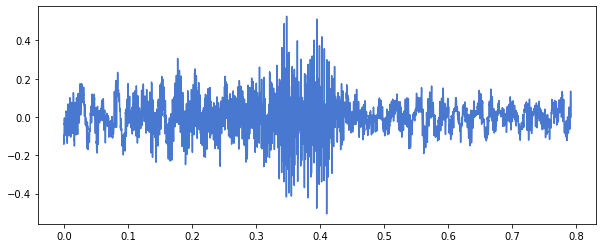

In [ ]:
#mix
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(mixed[1]))/8000, mixed[1])

- 混合前の風の音

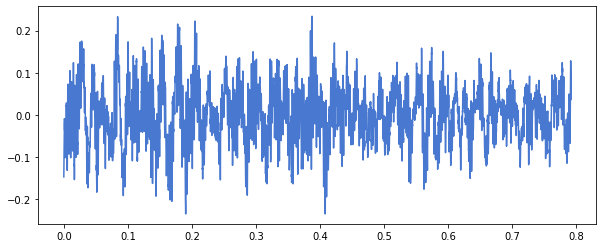

In [ ]:
#wind_before
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(before[1,0]))/8000, before[1,0])

- 分離後の風の音

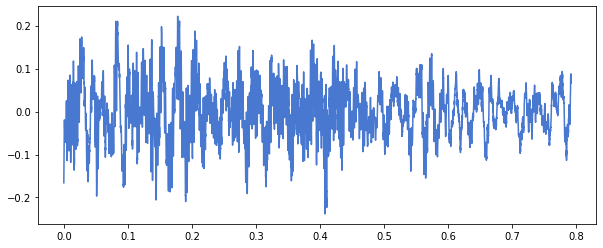

In [ ]:
#wind_after
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(after[1,1]))/8000, after[1,1])

- 混合前のカエルの鳴き声

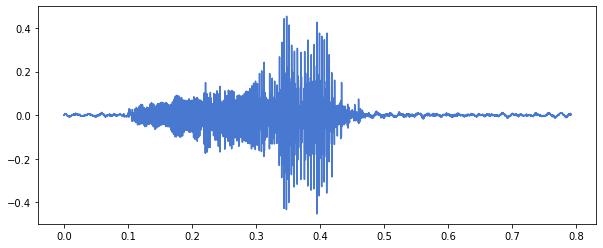

In [ ]:
#frog_before
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(before[1,1]))/8000, before[1,1])

- 分離後のカエルの鳴き声

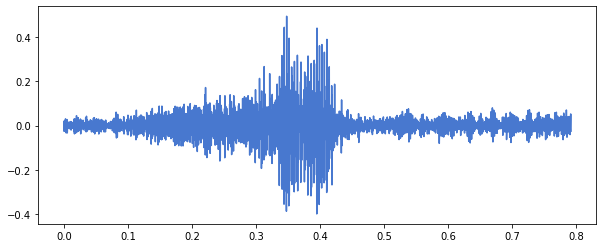

In [ ]:
#frog_after
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(after[1,0]))/8000, after[1,0])